In [13]:
#importing way more than we need:
import tensorflow.keras,sklearn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow.compat.v1 as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
seed=4
np.random.seed(seed)
tf.set_random_seed(seed)
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import requests
import io
from PIL import Image, ImageTk
import tkinter as tk
from tkinter.filedialog import asksaveasfilename
from tkinter.filedialog import askopenfilename
from numpy import asarray
import time
import pathlib
print('working directory:',pathlib.Path().absolute())
#should run on 2.4.0
print('tensorflow version',tf.__version__)

working directory: C:\Users\Warsh\ML_Notebooks_edited\mlqdproj\proj_notebooks
tensorflow version 2.4.0


# QD Trainer Program
This is a program put together using scraps from various other notebooks in the course by warsh to make training simple for the group/make sure everyone is on the same page as far as what parts of the dataset are being used.

In [14]:
all_cat_titles = ['airplane','monalisa','dragon','giraffe','axe','banana','eiffeltower','snail','windmill','snowman','schoolbus','smileyface','lollipop',]

img_rows, img_cols = 28, 28 

use_dataset_titles = ['X_use','Y_use']
ottest = ['ot1','ot2']
#DONT YOU DARE TOUCH THE ONLYTEST FILES.
#IF YOU ARE TRAINING A NEURAL NETWORK, TRAIN, VALIDATE, AND TEST FROM THE 'USE' FILES.

#load data
url_main = 'https://physics.bu.edu/~warsh/ML_QD/'
datalib={}

#loading samples
response = requests.get(url_main + use_dataset_titles[0] +'.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content), allow_pickle=False)
data = data.reshape(data.shape[0], img_rows*img_cols)
datalib[use_dataset_titles[0]] = data

response = requests.get(url_main + use_dataset_titles[1] +'.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content), allow_pickle=False)
datalib[use_dataset_titles[1]] = data

num_classes = int(max(datalib['Y_use'])+1)
cat_titles = all_cat_titles[:num_classes]
print('loaded:',cat_titles)

loaded: ['airplane', 'monalisa', 'dragon', 'giraffe', 'axe', 'banana', 'eiffeltower', 'snail', 'windmill', 'snowman']


an example of a data point with label axe


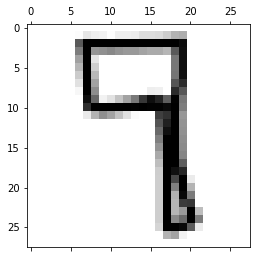

an example of a data point with label airplane


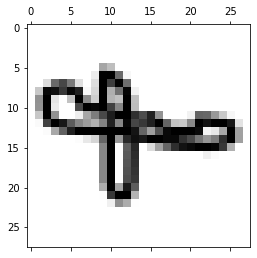

X_train shape: (86314, 28, 28, 1)
Y_train shape: (86314, 10)
X_valid shape: (21578, 28, 28, 1)
Y_valid shape: (21578, 10)
X_test shape: (26973, 28, 28, 1)
Y_test shape: (26973, 10)

86314 train samples
21578 validation samples
26973 test samples
134865 total


In [17]:
#format, delegate, and scale data
Y_use = datalib['Y_use']
X_use = datalib['X_use']

#use small portion, randomized already:
ratio_use=.1
numosamps = len(Y_use)*ratio_use #number of samples used for train, validation, and testsets
test_size=.2 #20% test
tr2valr=.8 #64% train, 16% validation
num_classes=int(max(Y_use)+1)

#scramble and split!
X_tr, X_test, Y_tr, Y_test = train_test_split(X_use, Y_use, test_size=test_size, train_size=1.0-test_size)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_tr,Y_tr,train_size=tr2valr,test_size=1-tr2valr)

#how much we usin'
X_train = X_train[0:int(numosamps*(1.0-test_size)*tr2valr)]
Y_train = Y_train[0:int(numosamps*(1.0-test_size)*tr2valr)]
X_valid = X_valid[0:int(numosamps*(1.0-test_size)*(1.0-tr2valr))]
Y_valid = Y_valid[0:int(numosamps*(1.0-test_size)*(1.0-tr2valr))]
X_test = X_test[0:int(numosamps*test_size)]
Y_test = Y_test[0:int(numosamps*test_size)]

#reshape into 2D
X_train = X_train.reshape(X_train.shape[0],img_rows,img_cols)
X_valid = X_valid.reshape(X_valid.shape[0],img_rows,img_cols)
X_test = X_test.reshape(X_test.shape[0],img_rows,img_cols)

#yeah okay some floats
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

#scale onto the fun zer-O to O-ne inverval
X_train /= 255
X_valid /= 255
X_test /= 255

#display some stuff
for i in range(2):
    print('an example of a data point with label', cat_titles[int(Y_train[i])])
    plt.matshow(X_train[i,:],cmap='binary')
    plt.show()

# converting the actual numbers to the the one-hot vectors
Y_train = tensorflow.keras.utils.to_categorical(Y_train, num_classes)
Y_test = tensorflow.keras.utils.to_categorical(Y_test, num_classes)
Y_valid = tensorflow.keras.utils.to_categorical(Y_valid, num_classes)

#reshape data, depending on Keras backend, final data formatting
if tensorflow.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols,1)
    input_shape = (img_rows, img_cols, 1)

#more debugging shit
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_valid shape:', X_valid.shape)
print('Y_valid shape:', Y_valid.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

print(X_train.shape[0]+X_valid.shape[0]+X_test.shape[0], 'total')

In [20]:
#CNN pulled straight from Prof's NBs, edit this how you like, do whatever you want with your architecture.
def create_CNN(nm):
    # instantiate model
    model = Sequential(name=nm)
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    # add 2D pooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # add second convolutional layer with 20 filters
    model.add(Conv2D(20, (5, 5), activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.25))
    # add 2D pooling layer
    model.add(MaxPooling2D(pool_size=(4, 4)))
    
    
    # flatten data
    model.add(Flatten())
    # add a dense all-to-all relu layer
    model.add(Dense(20*4*4, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.25))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile the model
    model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    #lil something special to show us our architecture traits
    model.summary()
    return model

In [21]:
modelname='pls'

# training parameters
batch_size = 64
epochs = 5

# create the deep conv net
model_CNN=create_CNN(modelname)

# train CNN
model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, Y_valid))

#evaluate model
score = model_CNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "pls"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 10)        260       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 20)          5020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 20)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 320)               25920   

In [56]:
#save trained model, make sure you have your path set up for this before running, also figure out your filenames
#file saving stuff

workdir = str(pathlib.Path().absolute())+'\\'
saveset=True
modelName=modelname
if saveset==True:
    modpath = workdir+modelName
    savfil = modpath
    i=1
    yeet=False
    if os.path.exists(savfil+'.h5')==True:
        print(savfil+'.h5 already exists, please choose different name')
    else:
        model_CNN.save(savfil+'.h5')#the last trained model is called model_CNN
        yeet=True
        print("Saved model to disk: "+savfil+'.h5')

Saved model to disk: C:/Users/Warsh/ML_Notebooks_edited/mlqdproj/models/pls.h5
